In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# How To Define Constants

In [2]:
PATH_TO_DATA = './data'
PATH_TO_DATASET_TABLE = './dataset.csv'

IMAGE_SIZE = (3840, 2160) # (width, height) Ultra HD 4K
FRAME_SIZE = (256, 256) # (frame_width, frame_height)
OVERLAY_SIZE = (1, 1) # (stride_x, stride_y)
BATCH_SIZE = 144

# How to Create Dataset Table

In [3]:
from utils import make_dataset_table, train_test_split

In [4]:
make_dataset_table(PATH_TO_DATA, PATH_TO_DATASET_TABLE)
train_test_split(PATH_TO_DATASET_TABLE, test_size=0.2)

# How To Use Slicing And Gluing

In [5]:
from utils import slicing, gluing

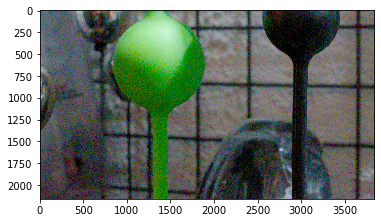

In [6]:
t = pd.read_csv(PATH_TO_DATASET_TABLE)
img = Image.open(t[t['phase']=='test'].iloc[0]['image']).resize(IMAGE_SIZE) # PIL Image
np_img = np.array(img) # numpy array from PIL Image
plt.imshow(np_img);

In [7]:
frames, overlay_mask = slicing(np_img,
                               frame_size=FRAME_SIZE,
                               overlay_size=OVERLAY_SIZE)

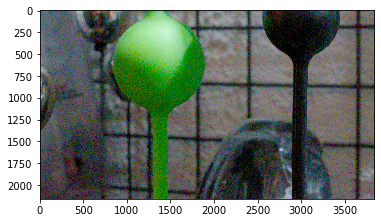

In [8]:
plt.imshow(gluing(frames, overlay_mask, overlay_size=OVERLAY_SIZE));

# How To Use Transforms

In [9]:
from conversion_transforms import _ToTensor, _ToNumpy
from geometric_transforms import _RandomHorizontalFlip, _RandomVerticalFlip
from color_transforms import _ColorJitter

### Conversion Transforms

In [10]:
print('Image shape: {}'.format(np_img.shape))
print('Tensor shape: {}'.format(_ToTensor()((np_img, None)).shape))
print('Image shape after transform _ToNumpy(): {}'.format(_ToNumpy()((_ToTensor()((np_img, None)), None)).shape))

Image shape: (2160, 3840, 3)
Tensor shape: torch.Size([3, 2160, 3840])
Image shape after transform _ToNumpy(): (2160, 3840, 3)


### Geometric Transforms

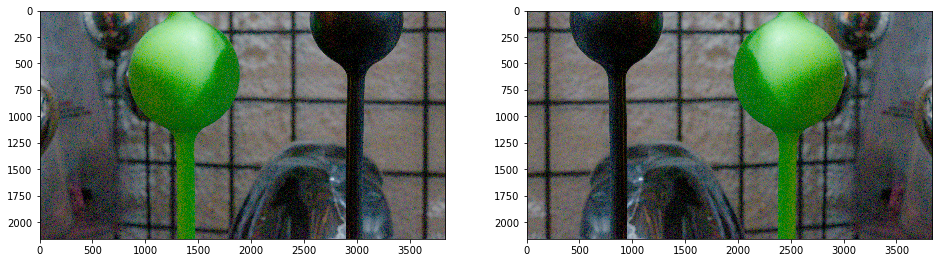

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes[0].imshow(img);
axes[1].imshow(_RandomHorizontalFlip(p=1.0)((img, img))[0]);

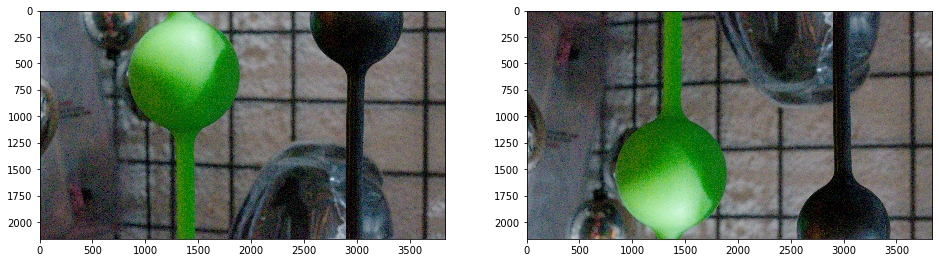

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes[0].imshow(img);
axes[1].imshow(_RandomVerticalFlip(p=1.0)((img, img))[0]);

### Color Transforms

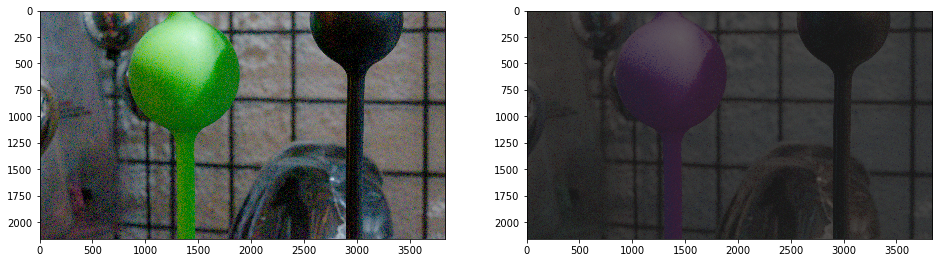

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes[0].imshow(img);
axes[1].imshow(_ColorJitter(brightness=(0.5, 1.0),
                            contrast=(0.3, 1.0),
                            saturation=(0.5, 1.0),
                            hue=0.5)((img, img))[0]);

# How To Create Dataset With Different Type Of Transforms

In [14]:
from torchvision import transforms
from torch.utils.data import ConcatDataset

from dataset import DenoisingDataset

In [15]:
transforms = [transforms.Compose([_RandomHorizontalFlip(p=1.0), _ToTensor()]),
              transforms.Compose([_RandomVerticalFlip(p=1.0), _ToTensor()]),
              transforms.Compose([_ColorJitter(hue=0.5), _ToTensor()])]

train_dataset = []
for transform in transforms:
    dataset = DenoisingDataset(dataset=pd.read_csv(PATH_TO_DATASET_TABLE),
                               image_size=IMAGE_SIZE,
                               frame_size=FRAME_SIZE,
                               overlay_size=OVERLAY_SIZE,
                               phase='train',
                               transform=transform)
    train_dataset = ConcatDataset([train_dataset, dataset])

In [16]:
len(train_dataset)

432

# How To Create Dataloader

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False, # can be set to True only for train loader
                          num_workers=0)
print(len(train_loader))

3


In [19]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([144, 3, 256, 256])

In [20]:
type(_ToNumpy()((batch[0][0], None)))

numpy.ndarray

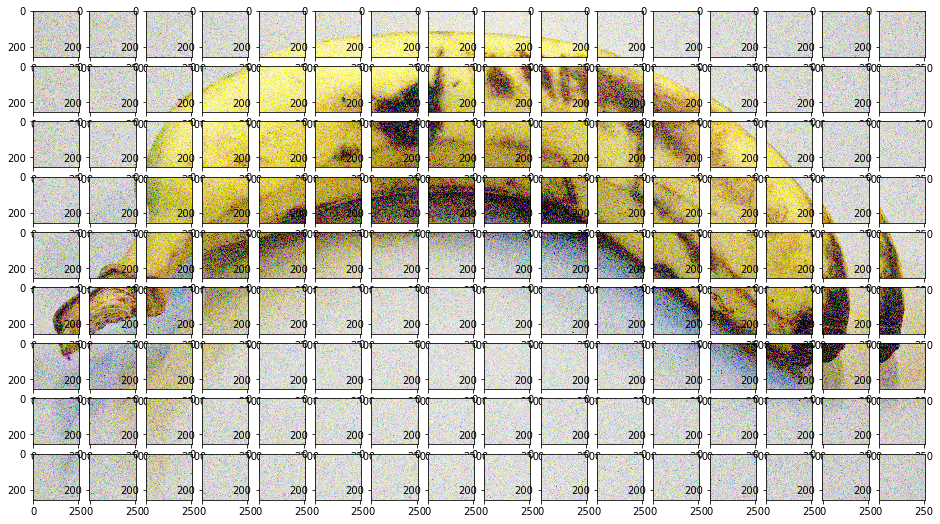

In [21]:
fig, axes = plt.subplots(ncols=16, nrows=9, figsize=(16, 9))
for i, ax in enumerate(axes.flat):
    im = Image.fromarray(_ToNumpy()((batch[0][i], None)))
    ax.imshow(_RandomHorizontalFlip(p=1.0)((im, im))[0]);

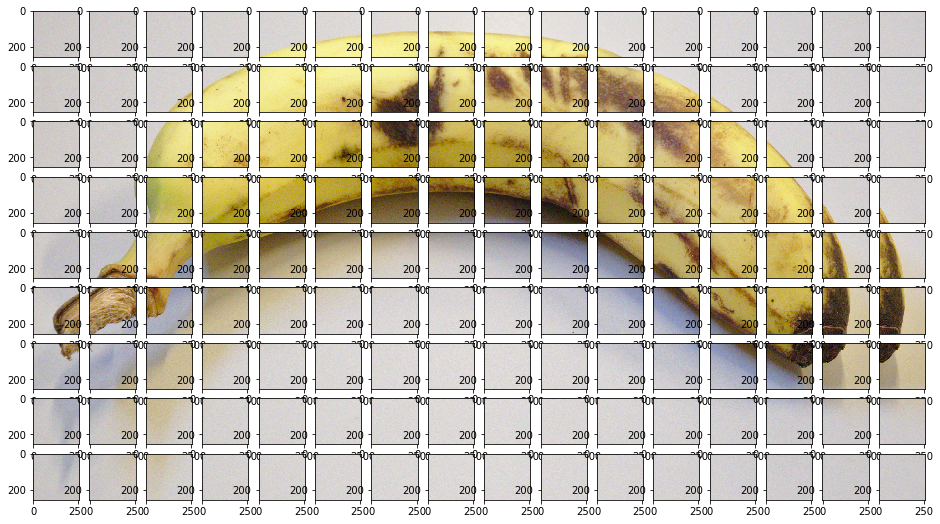

In [22]:
fig, axes = plt.subplots(ncols=16, nrows=9, figsize=(16, 9))
for i, ax in enumerate(axes.flat):
    im = Image.fromarray(_ToNumpy()((batch[1][i], None)))
    ax.imshow(_RandomHorizontalFlip(p=1.0)((im, im))[0]);